In [156]:
import pandas as pd
import numpy as np

In [158]:
df_1 = pd.read_csv("data/raw/2020-2021.csv")
df_1.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 106 columns):
 #    Column     Dtype  
---   ------     -----  
 0    Div        object 
 1    Date       object 
 2    Time       object 
 3    HomeTeam   object 
 4    AwayTeam   object 
 5    FTHG       int64  
 6    FTAG       int64  
 7    FTR        object 
 8    HTHG       int64  
 9    HTAG       int64  
 10   HTR        object 
 11   Referee    object 
 12   HS         int64  
 13   AS         int64  
 14   HST        int64  
 15   AST        int64  
 16   HF         int64  
 17   AF         int64  
 18   HC         int64  
 19   AC         int64  
 20   HY         int64  
 21   AY         int64  
 22   HR         int64  
 23   AR         int64  
 24   B365H      float64
 25   B365D      float64
 26   B365A      float64
 27   BWH        float64
 28   BWD        float64
 29   BWA        float64
 30   IWH        float64
 31   IWD        float64
 32   IWA        float64
 33   PSH        fl

In [160]:
for c in df_1.columns:
    print(c)

Div
Date
Time
HomeTeam
AwayTeam
FTHG
FTAG
FTR
HTHG
HTAG
HTR
Referee
HS
AS
HST
AST
HF
AF
HC
AC
HY
AY
HR
AR
B365H
B365D
B365A
BWH
BWD
BWA
IWH
IWD
IWA
PSH
PSD
PSA
WHH
WHD
WHA
VCH
VCD
VCA
MaxH
MaxD
MaxA
AvgH
AvgD
AvgA
B365>2.5
B365<2.5
P>2.5
P<2.5
Max>2.5
Max<2.5
Avg>2.5
Avg<2.5
AHh
B365AHH
B365AHA
PAHH
PAHA
MaxAHH
MaxAHA
AvgAHH
AvgAHA
B365CH
B365CD
B365CA
BWCH
BWCD
BWCA
IWCH
IWCD
IWCA
PSCH
PSCD
PSCA
WHCH
WHCD
WHCA
VCCH
VCCD
VCCA
MaxCH
MaxCD
MaxCA
AvgCH
AvgCD
AvgCA
B365C>2.5
B365C<2.5
PC>2.5
PC<2.5
MaxC>2.5
MaxC<2.5
AvgC>2.5
AvgC<2.5
AHCh
B365CAHH
B365CAHA
PCAHH
PCAHA
MaxCAHH
MaxCAHA
AvgCAHH
AvgCAHA


In [162]:
#since there are 106 columns in the dataset, I will extract the 20 key columns to work with
#So now I'll create a list with the columns I want
base_cols = [
   
    
    "HomeTeam",
    "AwayTeam",
    "FTHG",
    "FTAG",
    "FTR",
    "B365H",
    "B365D",
    "B365A",
    "HTHG",
    "HTAG",
    "HTR",
    "Attendance",
    "Referee",
    "HS",
    "AS",
    "HST",
    "AST",
    "HC",
    "AC",
    "HF",
    "AF",
    "HFKC",
    "AFKC",
    "HO",
    "AO",
    "HY",
    "AY",
    "HR",
    "AR",
    "HBP",
    "ABP",
    "Time",
    "Date",
    "Div",
    
]
existing_cols = [c for c in base_cols if c in df_1.columns]
df = df_1[existing_cols].copy()





In [164]:
#and now we will do some basic statistics about total shots, cards etc

In [182]:
df["total_goals"] = df["FTHG"] + df["FTAG"]
df["total_corners"] = df["HC"] + df["AC"]
df["home_shot_accuracy"] = np.where(
    df["HS"] > 0,
    df["HST"] / df["HS"],
    0
)
df["away_shot_accuracy"] = np.where(
    df["AS"] > 0,
    df["AST"] / df["AS"],
    0
)
df["home_shot_accuracy"] = df["home_shot_accuracy"].round(2)
df["away_shot_accuracy"] = df["away_shot_accuracy"].round(2)
df["total_yellow_cards"] = df["HY"] + df["AY"]
df["total_red_cards"] = df["HR"] + df["AR"]

df

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A,HTHG,HTAG,...,AR,Time,Date,Div,total_goals,total_corners,home_shot_accuracy,away_shot_accuracy,total_yellow_cards,total_red_cards
0,Fulham,Arsenal,0,3,A,6.00,4.33,1.53,0,1,...,0,12:30,12/09/2020,E0,3,5,0.40,0.46,4,0
1,Crystal Palace,Southampton,1,0,H,3.10,3.25,2.37,1,0,...,0,15:00,12/09/2020,E0,1,10,0.60,0.56,3,0
2,Liverpool,Leeds,4,3,H,1.28,6.00,9.50,3,2,...,0,17:30,12/09/2020,E0,7,9,0.27,0.50,1,0
3,West Ham,Newcastle,0,2,A,2.15,3.40,3.40,0,0,...,0,20:00,12/09/2020,E0,2,15,0.20,0.13,4,0
4,West Brom,Leicester,0,3,A,3.80,3.60,1.95,0,0,...,0,14:00,13/09/2020,E0,3,7,0.14,0.54,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,Liverpool,Crystal Palace,2,0,H,1.14,8.50,15.00,1,0,...,0,16:00,23/05/2021,E0,2,15,0.26,0.80,4,0
376,Man City,Everton,5,0,H,1.44,5.00,6.50,2,0,...,0,16:00,23/05/2021,E0,5,12,0.52,0.38,4,0
377,Sheffield United,Burnley,1,0,H,2.80,3.60,2.40,1,0,...,0,16:00,23/05/2021,E0,1,17,0.25,0.30,4,0
378,West Ham,Southampton,3,0,H,1.65,4.00,5.00,2,0,...,0,16:00,23/05/2021,E0,3,5,0.50,0.29,3,0


In [194]:
#some other stats


home_goals_per_team = df.groupby("HomeTeam")["FTHG"].sum()
away_goals_per_team = df.groupby("AwayTeam")["FTAG"].sum()

team_goals = home_goals_per_team.add(away_goals_per_team, fill_value=0)

team_goals = team_goals.reset_index()
team_goals.columns = ["Teams", "Total_Goals"]

team_goals.sort_values("Total_Goals", ascending = False).head(10)

#for future reference:
team_goals.to_csv("team_goals_summary.csv", index=False)


,Teams,Total_Goals
11,Man City,83
12,Man United,73
10,Liverpool,68
9,Leicester,68
16,Tottenham,68
18,West Ham,62
8,Leeds,62
4,Chelsea,58
1,Aston Villa,55
0,Arsenal,55


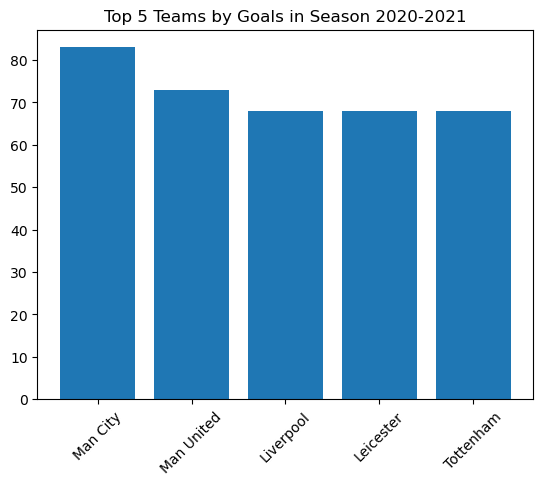

In [200]:
import matplotlib.pyplot as plt

top5 = team_goals.sort_values("Total_Goals", ascending=False).head(5)

plt.figure()
plt.bar(top5["Teams"], top5["Total_Goals"])
plt.xticks(rotation=45)
plt.title("Top 5 Teams by Goals in Season 2020-2021")
plt.show()

In [202]:
#same thing about yellow cards
home_yellows = df.groupby("HomeTeam")["HY"].sum()
away_yellows = df.groupby("AwayTeam")["AY"].sum()

total_yellows = home_yellows.add(away_yellows, fill_value=0)

total_yellows = total_yellows.reset_index()
total_yellows.columns = ["Team", "Total_Yellow_Cards"]

total_yellows.sort_values("Total_Yellow_Cards", ascending=False).head()

,Team,Total_Yellow_Cards
14,Sheffield United,73
7,Fulham,66
12,Man United,64
1,Aston Villa,63
8,Leeds,61
